# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
K_SIZE = 5

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

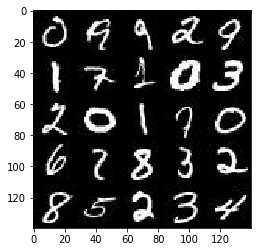

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

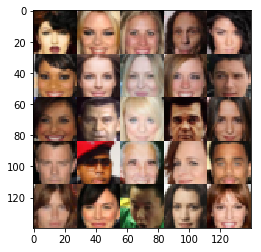

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_image = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_data = tf.placeholder(tf.float32, [None, z_dim])
    lr = tf.placeholder(tf.float32)
                                 

    return input_image, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False, alpha = 0.2, conv_kernel_size = K_SIZE):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        #depth=3
        conv_layer_1 = tf.layers.conv2d(images, filters = 32, kernel_size = conv_kernel_size, strides = 2, padding='same')
        relu_layer_1 = tf.maximum(alpha * conv_layer_1, conv_layer_1)
        #depth=32
        
        conv_layer_2 = tf.layers.conv2d(relu_layer_1, filters = 64, kernel_size = conv_kernel_size, strides = 2, padding='same')
        bn_layer_2 = tf.layers.batch_normalization(conv_layer_2, training=True)
        relu_layer_2 = tf.maximum(alpha * bn_layer_2, bn_layer_2)
        #depth = 64
        
        conv_layer_3 = tf.layers.conv2d(bn_layer_2, filters = 128, kernel_size = conv_kernel_size, strides = 2, padding='same')
        bn_layer_3 = tf.layers.batch_normalization(conv_layer_3, training=True)
        relu_layer_3 = tf.maximum(alpha * bn_layer_3, bn_layer_3)
        #depth = 128
        
        #figure out how big the data is
        x_shape = relu_layer_3.get_shape()
        n_data = 1
        for n_dim in x_shape[1:]:
            n_data = n_data * int(n_dim)
        
        dense_input = tf.reshape(relu_layer_3, [-1, n_data])
        
        logits = tf.layers.dense(dense_input, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
(not True)

False

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha = .2, conv_kernel_size = K_SIZE):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        start_size = int(z.get_shape()[1])
        
        output_w_h = 28
        start_w_h = output_w_h // 4
        
        x = tf.layers.dense(z, start_size*start_w_h*start_w_h)
        x = tf.reshape(x, (-1, start_w_h,start_w_h,start_size))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d_transpose(x, filters = 512, kernel_size = conv_kernel_size, strides = 2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d_transpose(x, filters = out_channel_dim, kernel_size = conv_kernel_size, strides = 2, padding='same')
#         x = tf.layers.batch_normalization(x, training=is_train)
#         x = tf.maximum(alpha * x, x)
        
        # Output layer, 32x32x3
        logits = x
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_output_train  = generator(input_z, out_channel_dim, is_train=True)
    
    disc_output_real, disc_logits_real = discriminator(input_real, reuse=False)
    disc_output_fake, disc_logits_fake = discriminator(gen_output_train, reuse=True)
    
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.zeros_like(disc_logits_fake)))
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real, labels=tf.ones_like(disc_logits_fake)))
    disc_loss = disc_loss_real + disc_loss_fake
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.ones_like(disc_logits_fake)))
    
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    all_vars = tf.trainable_variables()
    disc_vars = [x for x in all_vars if x.name.startswith('discriminator')]
    gen_vars = [x for x in all_vars if x.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        # Optimize
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list=disc_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list=gen_vars)

    return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
#     print(data_shape)
    _, image_width, image_height, image_channels = data_shape
    real_data, z_data, lr_tensor = model_inputs(image_width, image_height, image_channels, z_dim)
    
    disc_loss, gen_loss = model_loss(real_data, z_data, image_channels)
    
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, learning_rate, beta1)
    
    gen_loss_list = []
    disc_loss_list = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            batch_counter = 0
            for batch_images in get_batches(batch_size):
                #figure out inputs
                z_data_values = np.random.uniform(-1, 1, (batch_size, z_dim))
#                 z_data_values = np.random.normal(loc=0.0, scale=.1, size=(batch_size, z_dim))
                input_values_dict = {real_data : batch_images, z_data : z_data_values, lr_tensor : learning_rate}
                
                #run optimizers
                _ = sess.run(disc_opt, feed_dict = {real_data : batch_images, z_data : z_data_values, lr_tensor : learning_rate})
                _ = sess.run(gen_opt, feed_dict = {real_data : batch_images, z_data : z_data_values, lr_tensor : learning_rate})
                
                if batch_counter % 10 == 0:
                    #calculate loss
                    disc_loss_val, gen_loss_val = sess.run([disc_loss, gen_loss], feed_dict = input_values_dict)
                    gen_loss_list.append(gen_loss_val)
                    disc_loss_list.append(disc_loss_val)
                    print("epoch {} / {} \t batch {} / {} \t generator loss: {} \t discriminator loss: {}".format(epoch_i + 1, epoch_count, batch_counter, '?', gen_loss_val, disc_loss_val))
                if batch_counter % 100 == 0:
                    #plot
                    show_generator_output(sess, n_images=25, input_z=z_data, out_channel_dim=image_channels, image_mode=data_image_mode)
                    
                    
                batch_counter += 1
        show_generator_output(sess, n_images=25, input_z=z_data, out_channel_dim=image_channels, image_mode=data_image_mode)
                    
                
    plt.figure()
    plt.plot(gen_loss_list, label="Gen Loss")
    plt.plot(disc_loss_list, label="Disc Loss")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

epoch 1 / 2 	 batch 0 / ? 	 generator loss: 0.8972685933113098 	 discriminator loss: 1.174532175064087


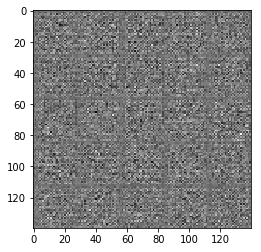

epoch 1 / 2 	 batch 10 / ? 	 generator loss: 0.5397588014602661 	 discriminator loss: 1.2697525024414062
epoch 1 / 2 	 batch 20 / ? 	 generator loss: 0.5209721326828003 	 discriminator loss: 1.1917409896850586
epoch 1 / 2 	 batch 30 / ? 	 generator loss: 0.4736447334289551 	 discriminator loss: 1.285959243774414
epoch 1 / 2 	 batch 40 / ? 	 generator loss: 0.42126500606536865 	 discriminator loss: 1.3554296493530273
epoch 1 / 2 	 batch 50 / ? 	 generator loss: 0.46266859769821167 	 discriminator loss: 1.2722587585449219
epoch 1 / 2 	 batch 60 / ? 	 generator loss: 0.42556047439575195 	 discriminator loss: 1.377198338508606
epoch 1 / 2 	 batch 70 / ? 	 generator loss: 0.462178498506546 	 discriminator loss: 1.3690662384033203
epoch 1 / 2 	 batch 80 / ? 	 generator loss: 0.4926794767379761 	 discriminator loss: 1.3306868076324463
epoch 1 / 2 	 batch 90 / ? 	 generator loss: 0.47894132137298584 	 discriminator loss: 1.3628350496292114
epoch 1 / 2 	 batch 100 / ? 	 generator loss: 0.487684

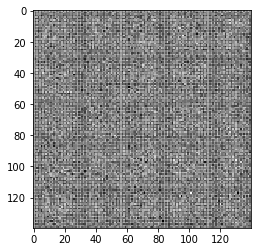

epoch 1 / 2 	 batch 110 / ? 	 generator loss: 0.5005895495414734 	 discriminator loss: 1.4116257429122925
epoch 1 / 2 	 batch 120 / ? 	 generator loss: 0.5442907214164734 	 discriminator loss: 1.2892224788665771
epoch 1 / 2 	 batch 130 / ? 	 generator loss: 0.6307536363601685 	 discriminator loss: 1.1874687671661377
epoch 1 / 2 	 batch 140 / ? 	 generator loss: 0.7026220560073853 	 discriminator loss: 1.079926609992981
epoch 1 / 2 	 batch 150 / ? 	 generator loss: 0.6853527426719666 	 discriminator loss: 1.1017314195632935
epoch 1 / 2 	 batch 160 / ? 	 generator loss: 0.6961191296577454 	 discriminator loss: 1.1283316612243652
epoch 1 / 2 	 batch 170 / ? 	 generator loss: 0.7021746039390564 	 discriminator loss: 1.1803810596466064
epoch 1 / 2 	 batch 180 / ? 	 generator loss: 0.7156195640563965 	 discriminator loss: 1.1132267713546753
epoch 1 / 2 	 batch 190 / ? 	 generator loss: 0.7230430841445923 	 discriminator loss: 1.1063470840454102
epoch 1 / 2 	 batch 200 / ? 	 generator loss: 0

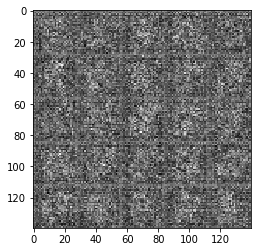

epoch 1 / 2 	 batch 210 / ? 	 generator loss: 0.7298806309700012 	 discriminator loss: 1.1123197078704834
epoch 1 / 2 	 batch 220 / ? 	 generator loss: 0.7424967885017395 	 discriminator loss: 1.154348611831665
epoch 1 / 2 	 batch 230 / ? 	 generator loss: 0.7540029883384705 	 discriminator loss: 1.274131178855896
epoch 1 / 2 	 batch 240 / ? 	 generator loss: 0.7517562508583069 	 discriminator loss: 1.1567164659500122
epoch 1 / 2 	 batch 250 / ? 	 generator loss: 0.756821870803833 	 discriminator loss: 1.2241278886795044
epoch 1 / 2 	 batch 260 / ? 	 generator loss: 0.745023250579834 	 discriminator loss: 1.3213621377944946
epoch 1 / 2 	 batch 270 / ? 	 generator loss: 0.7620995044708252 	 discriminator loss: 1.2950520515441895
epoch 1 / 2 	 batch 280 / ? 	 generator loss: 0.7376243472099304 	 discriminator loss: 1.3339197635650635
epoch 1 / 2 	 batch 290 / ? 	 generator loss: 0.7963249087333679 	 discriminator loss: 1.2837533950805664
epoch 2 / 2 	 batch 0 / ? 	 generator loss: 0.7952

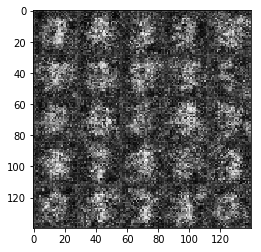

epoch 2 / 2 	 batch 10 / ? 	 generator loss: 0.8497471809387207 	 discriminator loss: 1.2612409591674805
epoch 2 / 2 	 batch 20 / ? 	 generator loss: 0.8321889042854309 	 discriminator loss: 1.2780189514160156
epoch 2 / 2 	 batch 30 / ? 	 generator loss: 0.8880699276924133 	 discriminator loss: 1.217195749282837
epoch 2 / 2 	 batch 40 / ? 	 generator loss: 0.8922855854034424 	 discriminator loss: 1.246661901473999
epoch 2 / 2 	 batch 50 / ? 	 generator loss: 0.9107301235198975 	 discriminator loss: 1.1689643859863281
epoch 2 / 2 	 batch 60 / ? 	 generator loss: 0.9153160452842712 	 discriminator loss: 1.1415942907333374
epoch 2 / 2 	 batch 70 / ? 	 generator loss: 0.9641252160072327 	 discriminator loss: 1.109659194946289
epoch 2 / 2 	 batch 80 / ? 	 generator loss: 0.9811767339706421 	 discriminator loss: 1.042931318283081
epoch 2 / 2 	 batch 90 / ? 	 generator loss: 0.9855703115463257 	 discriminator loss: 1.0497106313705444
epoch 2 / 2 	 batch 100 / ? 	 generator loss: 0.98859024047

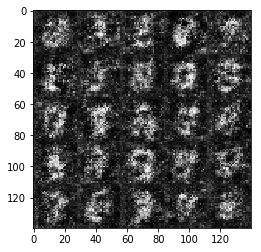

epoch 2 / 2 	 batch 110 / ? 	 generator loss: 0.9611833095550537 	 discriminator loss: 1.0671006441116333
epoch 2 / 2 	 batch 120 / ? 	 generator loss: 0.9111466407775879 	 discriminator loss: 1.1010712385177612
epoch 2 / 2 	 batch 130 / ? 	 generator loss: 0.9194896221160889 	 discriminator loss: 1.1112720966339111
epoch 2 / 2 	 batch 140 / ? 	 generator loss: 0.9513953924179077 	 discriminator loss: 1.0282732248306274
epoch 2 / 2 	 batch 150 / ? 	 generator loss: 0.9393466114997864 	 discriminator loss: 1.0699257850646973
epoch 2 / 2 	 batch 160 / ? 	 generator loss: 0.9043333530426025 	 discriminator loss: 1.099630355834961
epoch 2 / 2 	 batch 170 / ? 	 generator loss: 0.9135594367980957 	 discriminator loss: 1.1612401008605957
epoch 2 / 2 	 batch 180 / ? 	 generator loss: 0.9175013303756714 	 discriminator loss: 1.0542525053024292
epoch 2 / 2 	 batch 190 / ? 	 generator loss: 0.9217037558555603 	 discriminator loss: 1.1073075532913208
epoch 2 / 2 	 batch 200 / ? 	 generator loss: 0

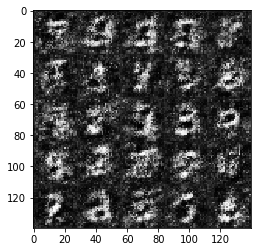

epoch 2 / 2 	 batch 210 / ? 	 generator loss: 0.9191921949386597 	 discriminator loss: 1.068101406097412
epoch 2 / 2 	 batch 220 / ? 	 generator loss: 0.9269997477531433 	 discriminator loss: 1.087372064590454
epoch 2 / 2 	 batch 230 / ? 	 generator loss: 0.9035054445266724 	 discriminator loss: 1.1507219076156616
epoch 2 / 2 	 batch 240 / ? 	 generator loss: 0.9337427616119385 	 discriminator loss: 1.0383522510528564
epoch 2 / 2 	 batch 250 / ? 	 generator loss: 0.9245414733886719 	 discriminator loss: 1.077211618423462
epoch 2 / 2 	 batch 260 / ? 	 generator loss: 0.9275501370429993 	 discriminator loss: 1.1072231531143188
epoch 2 / 2 	 batch 270 / ? 	 generator loss: 0.9218431711196899 	 discriminator loss: 1.0743759870529175
epoch 2 / 2 	 batch 280 / ? 	 generator loss: 0.9426036477088928 	 discriminator loss: 1.0700464248657227
epoch 2 / 2 	 batch 290 / ? 	 generator loss: 0.9538381099700928 	 discriminator loss: 1.0426467657089233


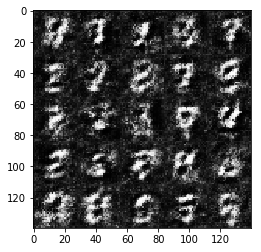

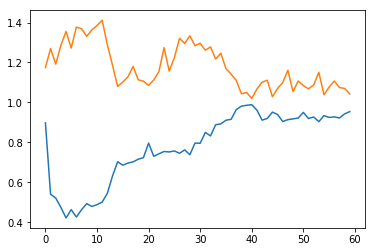

In [19]:
batch_size = 200
z_dim = 100
# learning_rate = .00001 # this was getting there but maybe needs faster rate
learning_rate = .000015
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

epoch 1 / 1 	 batch 0 / ? 	 generator loss: 0.463260680437088 	 discriminator loss: 1.6761494874954224


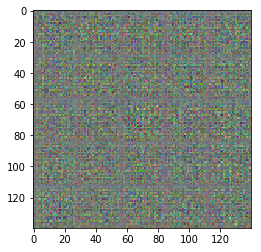

epoch 1 / 1 	 batch 10 / ? 	 generator loss: 0.21695344150066376 	 discriminator loss: 2.1392781734466553
epoch 1 / 1 	 batch 20 / ? 	 generator loss: 0.22757482528686523 	 discriminator loss: 1.9977902173995972
epoch 1 / 1 	 batch 30 / ? 	 generator loss: 0.25093647837638855 	 discriminator loss: 1.887176275253296
epoch 1 / 1 	 batch 40 / ? 	 generator loss: 0.2519543170928955 	 discriminator loss: 1.8602482080459595
epoch 1 / 1 	 batch 50 / ? 	 generator loss: 0.2541956901550293 	 discriminator loss: 1.8359187841415405
epoch 1 / 1 	 batch 60 / ? 	 generator loss: 0.24245622754096985 	 discriminator loss: 1.9322805404663086
epoch 1 / 1 	 batch 70 / ? 	 generator loss: 0.2414083182811737 	 discriminator loss: 1.8803064823150635
epoch 1 / 1 	 batch 80 / ? 	 generator loss: 0.2681700885295868 	 discriminator loss: 1.783170461654663
epoch 1 / 1 	 batch 90 / ? 	 generator loss: 0.28129759430885315 	 discriminator loss: 1.7552464008331299
epoch 1 / 1 	 batch 100 / ? 	 generator loss: 0.2939

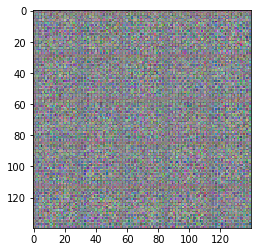

epoch 1 / 1 	 batch 110 / ? 	 generator loss: 0.27558937668800354 	 discriminator loss: 1.8177967071533203
epoch 1 / 1 	 batch 120 / ? 	 generator loss: 0.3064272999763489 	 discriminator loss: 1.7424925565719604
epoch 1 / 1 	 batch 130 / ? 	 generator loss: 0.3134889602661133 	 discriminator loss: 1.7151851654052734
epoch 1 / 1 	 batch 140 / ? 	 generator loss: 0.30844518542289734 	 discriminator loss: 1.7664744853973389
epoch 1 / 1 	 batch 150 / ? 	 generator loss: 0.3067811131477356 	 discriminator loss: 1.736316442489624
epoch 1 / 1 	 batch 160 / ? 	 generator loss: 0.33697229623794556 	 discriminator loss: 1.6352617740631104
epoch 1 / 1 	 batch 170 / ? 	 generator loss: 0.3797890841960907 	 discriminator loss: 1.575240135192871
epoch 1 / 1 	 batch 180 / ? 	 generator loss: 0.4012990891933441 	 discriminator loss: 1.4904285669326782
epoch 1 / 1 	 batch 190 / ? 	 generator loss: 0.43112072348594666 	 discriminator loss: 1.461182951927185
epoch 1 / 1 	 batch 200 / ? 	 generator loss:

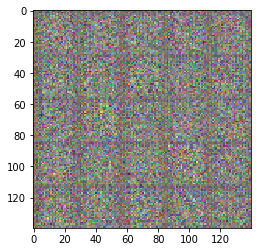

epoch 1 / 1 	 batch 210 / ? 	 generator loss: 0.5083086490631104 	 discriminator loss: 1.3502275943756104
epoch 1 / 1 	 batch 220 / ? 	 generator loss: 0.5876072645187378 	 discriminator loss: 1.2635318040847778
epoch 1 / 1 	 batch 230 / ? 	 generator loss: 0.5876269340515137 	 discriminator loss: 1.2923452854156494
epoch 1 / 1 	 batch 240 / ? 	 generator loss: 0.637794017791748 	 discriminator loss: 1.2834720611572266
epoch 1 / 1 	 batch 250 / ? 	 generator loss: 0.6681700944900513 	 discriminator loss: 1.1777732372283936
epoch 1 / 1 	 batch 260 / ? 	 generator loss: 0.6998381018638611 	 discriminator loss: 1.22426176071167
epoch 1 / 1 	 batch 270 / ? 	 generator loss: 0.7712578177452087 	 discriminator loss: 1.1616276502609253
epoch 1 / 1 	 batch 280 / ? 	 generator loss: 0.7236828207969666 	 discriminator loss: 1.1654237508773804
epoch 1 / 1 	 batch 290 / ? 	 generator loss: 0.7600798606872559 	 discriminator loss: 1.1868422031402588
epoch 1 / 1 	 batch 300 / ? 	 generator loss: 0.7

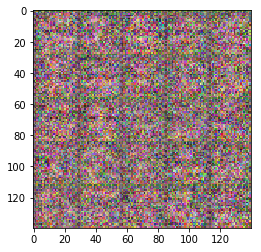

epoch 1 / 1 	 batch 310 / ? 	 generator loss: 0.767889678478241 	 discriminator loss: 1.1601788997650146
epoch 1 / 1 	 batch 320 / ? 	 generator loss: 0.8065139651298523 	 discriminator loss: 1.1324827671051025
epoch 1 / 1 	 batch 330 / ? 	 generator loss: 0.8488638401031494 	 discriminator loss: 1.0770936012268066
epoch 1 / 1 	 batch 340 / ? 	 generator loss: 0.9148158431053162 	 discriminator loss: 0.9712079763412476
epoch 1 / 1 	 batch 350 / ? 	 generator loss: 0.91403728723526 	 discriminator loss: 1.020017385482788
epoch 1 / 1 	 batch 360 / ? 	 generator loss: 0.953666090965271 	 discriminator loss: 1.0571167469024658
epoch 1 / 1 	 batch 370 / ? 	 generator loss: 0.9579740762710571 	 discriminator loss: 1.0293066501617432
epoch 1 / 1 	 batch 380 / ? 	 generator loss: 0.9295793175697327 	 discriminator loss: 1.0073435306549072
epoch 1 / 1 	 batch 390 / ? 	 generator loss: 0.9249753952026367 	 discriminator loss: 1.0703010559082031
epoch 1 / 1 	 batch 400 / ? 	 generator loss: 0.905

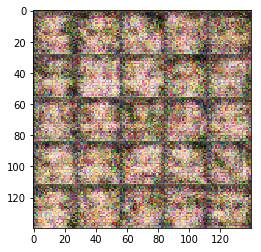

epoch 1 / 1 	 batch 410 / ? 	 generator loss: 0.9085193276405334 	 discriminator loss: 1.132129430770874
epoch 1 / 1 	 batch 420 / ? 	 generator loss: 0.873638927936554 	 discriminator loss: 1.1420279741287231
epoch 1 / 1 	 batch 430 / ? 	 generator loss: 0.883639395236969 	 discriminator loss: 1.181893229484558
epoch 1 / 1 	 batch 440 / ? 	 generator loss: 0.8470768928527832 	 discriminator loss: 1.2519621849060059
epoch 1 / 1 	 batch 450 / ? 	 generator loss: 0.759192168712616 	 discriminator loss: 1.3933480978012085
epoch 1 / 1 	 batch 460 / ? 	 generator loss: 0.808312177658081 	 discriminator loss: 1.3241913318634033
epoch 1 / 1 	 batch 470 / ? 	 generator loss: 0.8175557851791382 	 discriminator loss: 1.284676432609558
epoch 1 / 1 	 batch 480 / ? 	 generator loss: 0.7390151619911194 	 discriminator loss: 1.3688879013061523
epoch 1 / 1 	 batch 490 / ? 	 generator loss: 0.7910848259925842 	 discriminator loss: 1.3969128131866455
epoch 1 / 1 	 batch 500 / ? 	 generator loss: 0.72768

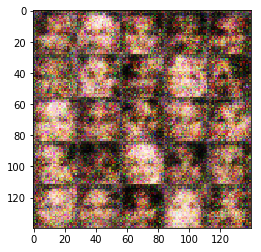

epoch 1 / 1 	 batch 510 / ? 	 generator loss: 0.7440194487571716 	 discriminator loss: 1.4479575157165527
epoch 1 / 1 	 batch 520 / ? 	 generator loss: 0.79465651512146 	 discriminator loss: 1.3307844400405884
epoch 1 / 1 	 batch 530 / ? 	 generator loss: 0.7743099331855774 	 discriminator loss: 1.3991408348083496
epoch 1 / 1 	 batch 540 / ? 	 generator loss: 0.7758445739746094 	 discriminator loss: 1.382749080657959
epoch 1 / 1 	 batch 550 / ? 	 generator loss: 0.7531285881996155 	 discriminator loss: 1.393524408340454
epoch 1 / 1 	 batch 560 / ? 	 generator loss: 0.7630825638771057 	 discriminator loss: 1.3713090419769287
epoch 1 / 1 	 batch 570 / ? 	 generator loss: 0.8027915954589844 	 discriminator loss: 1.3183984756469727
epoch 1 / 1 	 batch 580 / ? 	 generator loss: 0.7699971795082092 	 discriminator loss: 1.4358839988708496
epoch 1 / 1 	 batch 590 / ? 	 generator loss: 0.8080059289932251 	 discriminator loss: 1.3534746170043945
epoch 1 / 1 	 batch 600 / ? 	 generator loss: 0.80

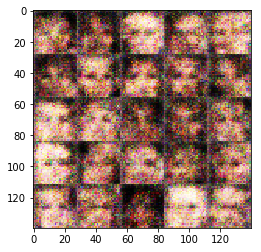

epoch 1 / 1 	 batch 610 / ? 	 generator loss: 0.8020215630531311 	 discriminator loss: 1.3075170516967773
epoch 1 / 1 	 batch 620 / ? 	 generator loss: 0.7603948712348938 	 discriminator loss: 1.3408554792404175
epoch 1 / 1 	 batch 630 / ? 	 generator loss: 0.8172531127929688 	 discriminator loss: 1.2932066917419434
epoch 1 / 1 	 batch 640 / ? 	 generator loss: 0.8363052010536194 	 discriminator loss: 1.2794114351272583
epoch 1 / 1 	 batch 650 / ? 	 generator loss: 0.8257659077644348 	 discriminator loss: 1.3189750909805298
epoch 1 / 1 	 batch 660 / ? 	 generator loss: 0.810754656791687 	 discriminator loss: 1.2816822528839111
epoch 1 / 1 	 batch 670 / ? 	 generator loss: 0.8118560314178467 	 discriminator loss: 1.3070189952850342
epoch 1 / 1 	 batch 680 / ? 	 generator loss: 0.7769092321395874 	 discriminator loss: 1.3189945220947266
epoch 1 / 1 	 batch 690 / ? 	 generator loss: 0.7955219745635986 	 discriminator loss: 1.2875736951828003
epoch 1 / 1 	 batch 700 / ? 	 generator loss: 0

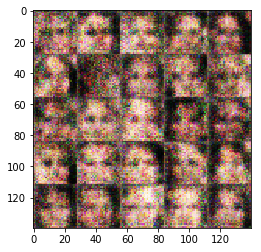

epoch 1 / 1 	 batch 710 / ? 	 generator loss: 0.8053113222122192 	 discriminator loss: 1.3331305980682373
epoch 1 / 1 	 batch 720 / ? 	 generator loss: 0.8262922167778015 	 discriminator loss: 1.2930241823196411
epoch 1 / 1 	 batch 730 / ? 	 generator loss: 0.8221787810325623 	 discriminator loss: 1.287886381149292
epoch 1 / 1 	 batch 740 / ? 	 generator loss: 0.8168017864227295 	 discriminator loss: 1.3077855110168457
epoch 1 / 1 	 batch 750 / ? 	 generator loss: 0.83829265832901 	 discriminator loss: 1.2237645387649536
epoch 1 / 1 	 batch 760 / ? 	 generator loss: 0.8609415292739868 	 discriminator loss: 1.1923184394836426
epoch 1 / 1 	 batch 770 / ? 	 generator loss: 0.843963623046875 	 discriminator loss: 1.245880365371704
epoch 1 / 1 	 batch 780 / ? 	 generator loss: 0.8522977828979492 	 discriminator loss: 1.2116578817367554
epoch 1 / 1 	 batch 790 / ? 	 generator loss: 0.814253032207489 	 discriminator loss: 1.1990094184875488
epoch 1 / 1 	 batch 800 / ? 	 generator loss: 0.8468

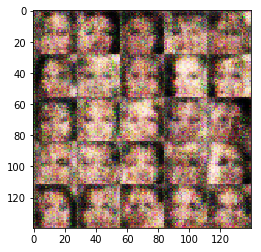

epoch 1 / 1 	 batch 810 / ? 	 generator loss: 0.8823441863059998 	 discriminator loss: 1.1723321676254272
epoch 1 / 1 	 batch 820 / ? 	 generator loss: 0.8315567970275879 	 discriminator loss: 1.1754896640777588
epoch 1 / 1 	 batch 830 / ? 	 generator loss: 0.8589461445808411 	 discriminator loss: 1.124694585800171
epoch 1 / 1 	 batch 840 / ? 	 generator loss: 0.8487522602081299 	 discriminator loss: 1.140091061592102
epoch 1 / 1 	 batch 850 / ? 	 generator loss: 0.878994882106781 	 discriminator loss: 1.1036728620529175
epoch 1 / 1 	 batch 860 / ? 	 generator loss: 0.8931412100791931 	 discriminator loss: 1.1313517093658447
epoch 1 / 1 	 batch 870 / ? 	 generator loss: 0.825465977191925 	 discriminator loss: 1.1773171424865723
epoch 1 / 1 	 batch 880 / ? 	 generator loss: 0.8388833403587341 	 discriminator loss: 1.163496971130371
epoch 1 / 1 	 batch 890 / ? 	 generator loss: 0.8372959494590759 	 discriminator loss: 1.1228342056274414
epoch 1 / 1 	 batch 900 / ? 	 generator loss: 0.918

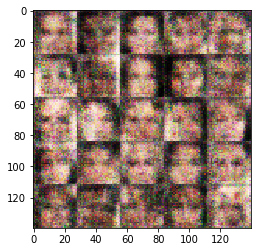

epoch 1 / 1 	 batch 910 / ? 	 generator loss: 0.8969923257827759 	 discriminator loss: 1.0899603366851807
epoch 1 / 1 	 batch 920 / ? 	 generator loss: 0.9004195928573608 	 discriminator loss: 1.1096045970916748
epoch 1 / 1 	 batch 930 / ? 	 generator loss: 0.8927974700927734 	 discriminator loss: 1.1370220184326172
epoch 1 / 1 	 batch 940 / ? 	 generator loss: 0.878640353679657 	 discriminator loss: 1.1476571559906006
epoch 1 / 1 	 batch 950 / ? 	 generator loss: 0.8826029896736145 	 discriminator loss: 1.1171884536743164
epoch 1 / 1 	 batch 960 / ? 	 generator loss: 0.8693253397941589 	 discriminator loss: 1.0833797454833984
epoch 1 / 1 	 batch 970 / ? 	 generator loss: 0.8896023631095886 	 discriminator loss: 1.0322234630584717
epoch 1 / 1 	 batch 980 / ? 	 generator loss: 0.8990757465362549 	 discriminator loss: 1.0608199834823608
epoch 1 / 1 	 batch 990 / ? 	 generator loss: 0.8423939347267151 	 discriminator loss: 1.1600520610809326
epoch 1 / 1 	 batch 1000 / ? 	 generator loss: 

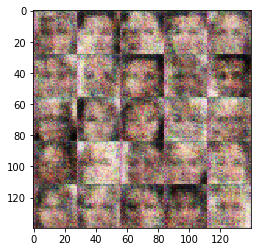

epoch 1 / 1 	 batch 1010 / ? 	 generator loss: 0.9485681653022766 	 discriminator loss: 1.0254936218261719


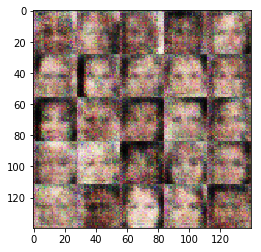

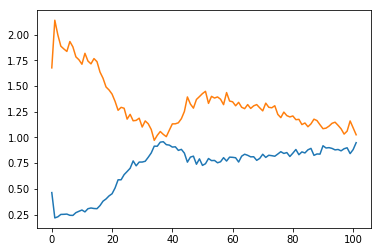

In [20]:
batch_size = 200
z_dim = 100
# learning_rate = .00001 # this was getting there but maybe needs faster rate
learning_rate = .000015
beta1 = .5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.